In [ ]:
# ======================================================
# 1. Imports
# ======================================================
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, BatchNormalization,
                                     Bidirectional, LSTM, Dense, Dropout,
                                     MultiHeadAttention, LayerNormalization, Reshape, Lambda)
from tensorflow.keras.models import Model

# ======================================================
# 2. Config
# ======================================================
DATA_PATH = r"iam/words"
WORDS_TXT = r"words.txt"

# charset
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
print("Charset size:", len(char_list))

# Transformer hyperparams
NUM_TRANSFORMER_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512

DROPOUT_RATE = 0.2

BATCH_SIZE = 32

# ======================================================
# 3. Image Preprocessing
# ======================================================
def process_image(img):
    img = cv2.resize(img, (128, 32))
    img = cv2.subtract(255, img)   # invert (text=1, bg=0)
    img = np.expand_dims(img, axis=-1).astype("float32") / 255.0
    return img

def encode_to_labels(txt):
    return [char_list.index(ch) for ch in txt if ch in char_list]

# ======================================================
# 4. Dataset Creation from words.txt
# ======================================================
train_images, train_labels = [], []
valid_images, valid_labels = [], []
max_label_len = 0

with open(WORDS_TXT, "r", encoding="utf-8", errors="ignore") as f:
    contents = f.readlines()[18:]  # skip IAM header

for index, line in enumerate(contents):
    splits = line.strip().split(" ")
    if len(splits) < 9 or splits[1] != "ok":
        continue

    word_id = splits[0]
    word = "".join(splits[8:])
    splits_id = word_id.split("-")
    filepath = f"{DATA_PATH}/{splits_id[0]}/{splits_id[0]}-{splits_id[1]}/{word_id}.png"

    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    img = process_image(img)
    label = encode_to_labels(word)

    if index % 10 == 0:
        valid_images.append(img)
        valid_labels.append(label)
    else:
        train_images.append(img)
        train_labels.append(label)

    max_label_len = max(max_label_len, len(label))

train_images = np.array(train_images)
valid_images = np.array(valid_images)

print("Dataset sizes: train:", len(train_images), "valid:", len(valid_images))
print("Max label length:", max_label_len)

# ======================================================
# 5. Pad Labels + Compute Lengths
# ======================================================
def pad_labels(labels, max_len):
    return tf.keras.preprocessing.sequence.pad_sequences(labels, maxlen=max_len,
                                                         padding="post", value=len(char_list))

train_labels_padded = pad_labels(train_labels, max_label_len)
valid_labels_padded = pad_labels(valid_labels, max_label_len)

train_label_lengths = np.array([len(l) for l in train_labels])
valid_label_lengths = np.array([len(l) for l in valid_labels])

# CNN downsamples width 128 → 31 time steps
train_input_length = np.full((len(train_images), 1), 31)
valid_input_length = np.full((len(valid_images), 1), 31)

# ======================================================
# 6. Wrap with tf.data.Dataset
# ======================================================
def create_tf_dataset(images, labels_padded, input_length, label_length, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "images": images,
            "labels": labels_padded,
            "input_length": input_length,
            "label_length": label_length,
        },
        np.zeros((images.shape[0],))  # dummy y
    ))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_images, train_labels_padded,
                                  train_input_length, train_label_lengths,
                                  batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = create_tf_dataset(valid_images, valid_labels_padded,
                                  valid_input_length, valid_label_lengths,
                                  batch_size=BATCH_SIZE, shuffle=False)

print("✅ tf.data.Dataset objects ready!")

Charset size: 78
Dataset sizes: train: 86818 valid: 9636
Max label length: 21
✅ tf.data.Dataset objects ready!


kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip



Transformer OCR output timesteps: 31
After filtering by timesteps - train: 86818 valid: 9636
Building an in-memory language model from corpus.txt...


Space token ' ' missing from vocabulary.


✅ Decoder initialized with in-memory language model.
Epoch 1/100

5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 8.9029
Epoch 1 - val_CER: 0.2257, val_WER: 0.5223

Epoch 1: val_cer improved from None to 0.22568, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1537s 282ms/step - loss: 6.1305 - val_loss: 3.3144 - val_cer: 0.2257 - val_wer: 0.5223 - learning_rate: 1.0000e-04
Epoch 2/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 3.3652
Epoch 2 - val_CER: 0.1703, val_WER: 0.4166

Epoch 2: val_cer improved from 0.22568 to 0.17029, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1574s 290ms/step - loss: 3.1318 - val_loss: 2.5491 - val_cer: 0.1703 - val_wer: 0.4166 - learning_rate: 1.0000e-04
Epoch 3/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 2.4547
Epoch 3 - val_CER: 0.1471, val_WER: 0.3729

Epoch 3: val_cer improved from 0.17029 to 0.14711, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1545s 285ms/step - loss: 2.3857 - val_loss: 2.1388 - val_cer: 0.1471 - val_wer: 0.3729 - learning_rate: 1.0000e-04
Epoch 4/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 1.9818
Epoch 4 - val_CER: 0.1295, val_WER: 0.3444

Epoch 4: val_cer improved from 0.14711 to 0.12949, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1571s 289ms/step - loss: 1.9801 - val_loss: 1.9276 - val_cer: 0.1295 - val_wer: 0.3444 - learning_rate: 1.0000e-04
Epoch 5/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 1.7046
Epoch 5 - val_CER: 0.1182, val_WER: 0.3202

Epoch 5: val_cer improved from 0.12949 to 0.11821, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1572s 290ms/step - loss: 1.7015 - val_loss: 1.7416 - val_cer: 0.1182 - val_wer: 0.3202 - learning_rate: 1.0000e-04
Epoch 6/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.4776
Epoch 6 - val_CER: 0.1106, val_WER: 0.3061

Epoch 6: val_cer improved from 0.11821 to 0.11065, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1562s 288ms/step - loss: 1.4930 - val_loss: 1.6501 - val_cer: 0.1106 - val_wer: 0.3061 - learning_rate: 1.0000e-04
Epoch 7/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 1.2979
Epoch 7 - val_CER: 0.1040, val_WER: 0.2844

Epoch 7: val_cer improved from 0.11065 to 0.10395, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1544s 284ms/step - loss: 1.3245 - val_loss: 1.5373 - val_cer: 0.1040 - val_wer: 0.2844 - learning_rate: 1.0000e-04
Epoch 8/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 1.1558
Epoch 8 - val_CER: 0.1023, val_WER: 0.2799

Epoch 8: val_cer improved from 0.10395 to 0.10232, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1559s 287ms/step - loss: 1.1944 - val_loss: 1.5413 - val_cer: 0.1023 - val_wer: 0.2799 - learning_rate: 1.0000e-04
Epoch 9/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 1.0438
Epoch 9 - val_CER: 0.0964, val_WER: 0.2698

Epoch 9: val_cer improved from 0.10232 to 0.09637, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1560s 287ms/step - loss: 1.0789 - val_loss: 1.4661 - val_cer: 0.0964 - val_wer: 0.2698 - learning_rate: 1.0000e-04
Epoch 10/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 0.9442
Epoch 10 - val_CER: 0.0985, val_WER: 0.2776

Epoch 10: val_cer did not improve from 0.09637
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 2934s 541ms/step - loss: 0.9788 - val_loss: 1.5124 - val_cer: 0.0985 - val_wer: 0.2776 - learning_rate: 1.0000e-04
Epoch 11/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 0.8559
Epoch 11 - val_CER: 0.0996, val_WER: 0.2712

Epoch 11: val_cer did not improve from 0.09637
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 2315s 427ms/step - loss: 0.8898 - val_loss: 1.5534 - val_cer: 0.0996 - val_wer: 0.2712 - learning_rate: 1.0000e-04
Epoch 12/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7974
Epoch 12 - val_CER: 0.0927, val_WER: 0.2589

Epoch 12: val_cer improved from 0.09637 to 0.09270, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 7047s 1s/step - loss: 0.8262 - val_loss: 1.4382 - val_cer: 0.0927 - val_wer: 0.2589 - learning_rate: 1.0000e-04
Epoch 13/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.7248
Epoch 13 - val_CER: 0.0977, val_WER: 0.2716

Epoch 13: val_cer did not improve from 0.09270
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1564s 288ms/step - loss: 0.7596 - val_loss: 1.5374 - val_cer: 0.0977 - val_wer: 0.2716 - learning_rate: 1.0000e-04
Epoch 14/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.6626
Epoch 14 - val_CER: 0.0996, val_WER: 0.2762

Epoch 14: val_cer did not improve from 0.09270
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1528s 282ms/step - loss: 0.7017 - val_loss: 1.5796 - val_cer: 0.0996 - val_wer: 0.2762 - learning_rate: 1.0000e-04
Epoch 15/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.6235
Epoch 15 - val_CER: 0.0856, val_WER: 0.2396

Epoch 15: val_cer improved from 0.09270 to 0.08558, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1381s 254ms/step - loss: 0.6565 - val_loss: 1.4110 - val_cer: 0.0856 - val_wer: 0.2396 - learning_rate: 1.0000e-04
Epoch 16/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.5781
Epoch 16 - val_CER: 0.0870, val_WER: 0.2465

Epoch 16: val_cer did not improve from 0.08558
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1377s 254ms/step - loss: 0.6114 - val_loss: 1.4833 - val_cer: 0.0870 - val_wer: 0.2465 - learning_rate: 1.0000e-04
Epoch 17/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.5493
Epoch 17 - val_CER: 0.0850, val_WER: 0.2464

Epoch 17: val_cer improved from 0.08558 to 0.08501, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1370s 253ms/step - loss: 0.5767 - val_loss: 1.4629 - val_cer: 0.0850 - val_wer: 0.2464 - learning_rate: 1.0000e-04
Epoch 18/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.5204
Epoch 18 - val_CER: 0.0849, val_WER: 0.2415

Epoch 18: val_cer improved from 0.08501 to 0.08486, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1421s 262ms/step - loss: 0.5453 - val_loss: 1.4491 - val_cer: 0.0849 - val_wer: 0.2415 - learning_rate: 1.0000e-04
Epoch 19/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.4923
Epoch 19 - val_CER: 0.0868, val_WER: 0.2455

Epoch 19: val_cer did not improve from 0.08486
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1367s 252ms/step - loss: 0.5168 - val_loss: 1.4821 - val_cer: 0.0868 - val_wer: 0.2455 - learning_rate: 1.0000e-04
Epoch 20/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.4582
Epoch 20 - val_CER: 0.0838, val_WER: 0.2392

Epoch 20: val_cer improved from 0.08486 to 0.08382, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1528s 281ms/step - loss: 0.4832 - val_loss: 1.4805 - val_cer: 0.0838 - val_wer: 0.2392 - learning_rate: 1.0000e-04
Epoch 21/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.4386
Epoch 21 - val_CER: 0.0836, val_WER: 0.2372

Epoch 21: val_cer improved from 0.08382 to 0.08362, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1403s 258ms/step - loss: 0.4605 - val_loss: 1.4908 - val_cer: 0.0836 - val_wer: 0.2372 - learning_rate: 1.0000e-04
Epoch 22/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4190
Epoch 22 - val_CER: 0.0848, val_WER: 0.2395

Epoch 22: val_cer did not improve from 0.08362
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 6721s 1s/step - loss: 0.4349 - val_loss: 1.5157 - val_cer: 0.0848 - val_wer: 0.2395 - learning_rate: 1.0000e-04
Epoch 23/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.3952
Epoch 23 - val_CER: 0.0828, val_WER: 0.2332

Epoch 23: val_cer improved from 0.08362 to 0.08283, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1565s 288ms/step - loss: 0.4236 - val_loss: 1.4973 - val_cer: 0.0828 - val_wer: 0.2332 - learning_rate: 1.0000e-04
Epoch 24/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.3827
Epoch 24 - val_CER: 0.0809, val_WER: 0.2306

Epoch 24: val_cer improved from 0.08283 to 0.08095, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1494s 275ms/step - loss: 0.4026 - val_loss: 1.5149 - val_cer: 0.0809 - val_wer: 0.2306 - learning_rate: 1.0000e-04
Epoch 25/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.3639
Epoch 25 - val_CER: 0.0905, val_WER: 0.2543

Epoch 25: val_cer did not improve from 0.08095
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1567s 289ms/step - loss: 0.3864 - val_loss: 1.6500 - val_cer: 0.0905 - val_wer: 0.2543 - learning_rate: 1.0000e-04
Epoch 26/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.3677
Epoch 26 - val_CER: 0.0839, val_WER: 0.2393

Epoch 26: val_cer did not improve from 0.08095
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1566s 289ms/step - loss: 0.3789 - val_loss: 1.5583 - val_cer: 0.0839 - val_wer: 0.2393 - learning_rate: 1.0000e-04
Epoch 27/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 0.3535
Epoch 27 - val_CER: 0.0831, val_WER: 0.2326

Epoch 27: val_cer did not improve from 0.08095
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1575s 290ms/step - loss: 0.3643 - va

5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1783s 329ms/step - loss: 0.2149 - val_loss: 1.4776 - val_cer: 0.0746 - val_wer: 0.2177 - learning_rate: 5.0000e-05
Epoch 31/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.1698
Epoch 31 - val_CER: 0.0770, val_WER: 0.2210

Epoch 31: val_cer did not improve from 0.07462
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1689s 311ms/step - loss: 0.1756 - val_loss: 1.5896 - val_cer: 0.0770 - val_wer: 0.2210 - learning_rate: 5.0000e-05
Epoch 32/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1528
Epoch 32 - val_CER: 0.0769, val_WER: 0.2218

Epoch 32: val_cer did not improve from 0.07462
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1710s 315ms/step - loss: 0.1606 - val_loss: 1.5644 - val_cer: 0.0769 - val_wer: 0.2218 - learning_rate: 5.0000e-05
Epoch 33/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.1486
Epoch 33 - val_CER: 0.0727, val_WER: 0.2075

Epoch 33: val_cer improved from 0.07462 to 0.07271, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1700s 313ms/step - loss: 0.1511 - val_loss: 1.5338 - val_cer: 0.0727 - val_wer: 0.2075 - learning_rate: 5.0000e-05
Epoch 34/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.1410
Epoch 34 - val_CER: 0.0750, val_WER: 0.2120

Epoch 34: val_cer did not improve from 0.07271
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1684s 310ms/step - loss: 0.1446 - val_loss: 1.6311 - val_cer: 0.0750 - val_wer: 0.2120 - learning_rate: 5.0000e-05
Epoch 35/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.1356
Epoch 35 - val_CER: 0.0752, val_WER: 0.2182

Epoch 35: val_cer did not improve from 0.07271
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1711s 315ms/step - loss: 0.1435 - val_loss: 1.6201 - val_cer: 0.0752 - val_wer: 0.2182 - learning_rate: 5.0000e-05
Epoch 36/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.1335
Epoch 36 - val_CER: 0.0749, val_WER: 0.2169

Epoch 36: val_cer did not improve from 0.07271
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1444s 266ms/step - loss: 0.1371 - va

5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1372s 253ms/step - loss: 0.1328 - val_loss: 1.6236 - val_cer: 0.0717 - val_wer: 0.2061 - learning_rate: 5.0000e-05
Epoch 38/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1158
Epoch 38 - val_CER: 0.0732, val_WER: 0.2108

Epoch 38: val_cer did not improve from 0.07172
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1373s 253ms/step - loss: 0.1259 - val_loss: 1.6108 - val_cer: 0.0732 - val_wer: 0.2108 - learning_rate: 5.0000e-05
Epoch 39/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.1197
Epoch 39 - val_CER: 0.0762, val_WER: 0.2191

Epoch 39: val_cer did not improve from 0.07172
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1379s 254ms/step - loss: 0.1244 - val_loss: 1.6917 - val_cer: 0.0762 - val_wer: 0.2191 - learning_rate: 5.0000e-05
Epoch 40/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1162
Epoch 40 - val_CER: 0.0712, val_WER: 0.2076

Epoch 40: val_cer improved from 0.07172 to 0.07118, saving model to best_transformerocrceer1.h5


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1378s 254ms/step - loss: 0.1214 - val_loss: 1.6144 - val_cer: 0.0712 - val_wer: 0.2076 - learning_rate: 5.0000e-05
Epoch 41/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.1147
Epoch 41 - val_CER: 0.0726, val_WER: 0.2114

Epoch 41: val_cer did not improve from 0.07118
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1371s 253ms/step - loss: 0.1205 - val_loss: 1.6677 - val_cer: 0.0726 - val_wer: 0.2114 - learning_rate: 5.0000e-05
Epoch 42/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.1042
Epoch 42 - val_CER: 0.0755, val_WER: 0.2210

Epoch 42: val_cer did not improve from 0.07118
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1377s 254ms/step - loss: 0.1128 - val_loss: 1.7219 - val_cer: 0.0755 - val_wer: 0.2210 - learning_rate: 5.0000e-05
Epoch 43/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1117
Epoch 43 - val_CER: 0.0726, val_WER: 0.2077

Epoch 43: val_cer did not improve from 0.07118
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 6575s 1s/step - loss: 0.1172 - val_loss

5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1567s 289ms/step - loss: 0.0789 - val_loss: 1.6561 - val_cer: 0.0682 - val_wer: 0.1959 - learning_rate: 2.5000e-05
Epoch 47/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0648
Epoch 47 - val_CER: 0.0694, val_WER: 0.2009

Epoch 47: val_cer did not improve from 0.06823
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1518s 280ms/step - loss: 0.0657 - val_loss: 1.6855 - val_cer: 0.0694 - val_wer: 0.2009 - learning_rate: 2.5000e-05
Epoch 48/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0607
Epoch 48 - val_CER: 0.0699, val_WER: 0.2053

Epoch 48: val_cer did not improve from 0.06823
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1524s 281ms/step - loss: 0.0601 - val_loss: 1.7253 - val_cer: 0.0699 - val_wer: 0.2053 - learning_rate: 2.5000e-05
Epoch 49/100
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0548
Epoch 49 - val_CER: 0.0699, val_WER: 0.2056

Epoch 49: val_cer did not improve from 0.06823
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 1532s 282ms/step - loss: 0.0586 - va

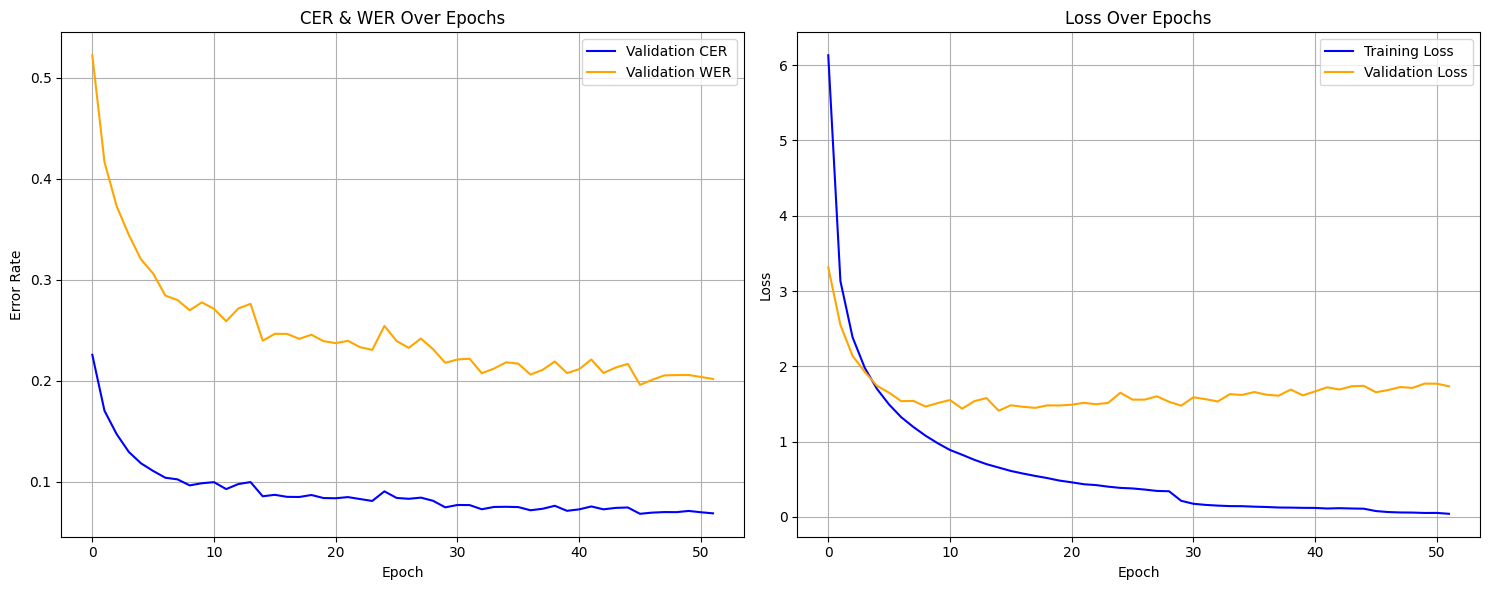


--- Best Model Performance ---
Best performance found at Epoch: 46
Lowest Validation CER: 0.0682
Validation WER at best CER: 0.1959


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, BatchNormalization,
                                     Lambda, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, RandomRotation) # Import RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyctcdecode import build_ctcdecoder

# (Your data loading code and variable definitions should be here)
# char_list, train_images, train_labels, etc.
# NUM_TRANSFORMER_LAYERS, D_MODEL, NUM_HEADS, DFF, DROPOUT_RATE

# --- I have set a default for DROPOUT_RATE in case it's not defined ---
if 'DROPOUT_RATE' not in locals():
    DROPOUT_RATE = 0.2 # Increased slightly to 0.2 for better regularization

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.d_model = d_model
        pos = np.arange(self.max_len)[:, np.newaxis]
        i = np.arange(self.d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))
        angle_rads = pos * angle_rates
        pos_enc = np.zeros_like(angle_rads)
        pos_enc[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_enc[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:seq_len, :]

def transformer_encoder_block(x, d_model, num_heads, dff, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2

def build_transformer_model(char_list,
                            num_layers,
                            d_model,
                            num_heads,
                            dff,
                            dropout_rate,
                            max_pos_len=128):
    if isinstance(char_list, str):
        char_list = list(char_list)
        
    inputs = Input(shape=(32, 128, 1), name='image_input')
    
    # ======================================================
    # NEW: DATA AUGMENTATION LAYER
    # This layer will only be active during training.
    # ======================================================
    x = RandomRotation(factor=0.02, fill_mode='constant', fill_value=0.0)(inputs)

    # CNN backbone (now starting from 'x' instead of 'inputs')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # ... (rest of the CNN is the same)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 1))(x)
    x = Conv2D(d_model, (2, 2), activation='relu')(x)

    x = Lambda(lambda t: K.squeeze(t, 1), name='squeeze_height')(x)
    x = PositionalEncoding(max_len=max_pos_len, d_model=d_model, name='pos_encoding')(x)

    for i in range(num_layers):
        x = transformer_encoder_block(x, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
    
    x = Dense(len(char_list) + 1, name='dense_logits')(x)
    outputs = tf.keras.layers.Activation('softmax', name='char_probs')(x)

    act_model = Model(inputs=inputs, outputs=outputs, name='transformer_ocr')
    return act_model, outputs, inputs


# Build active model
act_model, outputs, inputs = build_transformer_model(char_list, NUM_TRANSFORMER_LAYERS, D_MODEL, NUM_HEADS, DFF, DROPOUT_RATE)

# Data preparation steps
dummy_input = tf.ones((1, 32, 128, 1))
cnn_out = act_model(dummy_input)
timesteps = int(cnn_out.shape[1])
print("Transformer OCR output timesteps:", timesteps)
# ... (rest of data prep)
def filter_too_long(images, labels):
    new_images, new_labels = [], []
    for img, lbl in zip(images, labels):
        if len(lbl) <= timesteps:
            new_images.append(img)
            new_labels.append(lbl)
    return np.array(new_images), new_labels
train_images, train_labels = filter_too_long(train_images, train_labels)
valid_images, valid_labels = filter_too_long(valid_images, valid_labels)
print("After filtering by timesteps - train:", len(train_images), "valid:", len(valid_images))
train_padded_label = pad_sequences(train_labels, maxlen=max_label_len, padding="post", value=-1)
valid_padded_label = pad_sequences(valid_labels, maxlen=max_label_len, padding="post", value=-1)
train_input_length = np.ones((len(train_images), 1), dtype=np.int32) * timesteps
valid_input_length = np.ones((len(valid_images), 1), dtype=np.int32) * timesteps
train_label_length = np.array([len(lbl) for lbl in train_labels]).reshape(-1, 1)
valid_label_length = np.array([len(lbl) for lbl in valid_labels]).reshape(-1, 1)

# CTC wrapper model
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='int32')
input_length = Input(name='input_length', shape=[1], dtype='int32')
label_length = Input(name='label_length', shape=[1], dtype='int32')
def ctc_lambda_func(args):
    y_pred, labels, input_length_, label_length_ = args
    return K.ctc_batch_cost(labels, y_pred, input_length_, label_length_)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=1e-4))

# Levenshtein distance function
def levenshtein(a, b):
    n, m = len(a), len(b)
    if n > m: a, b = b, a; n, m = m, n
    current = list(range(n + 1))
    for i in range(1, m + 1):
        previous, current = current, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete = previous[j] + 1, current[j - 1] + 1
            change = previous[j - 1] + (a[j - 1] != b[i - 1])
            current[j] = min(add, delete, change)
    return current[n]

# Evaluation Callback
class EvaluateCER_WER(Callback):
    def __init__(self, prediction_model, validation_data, char_list):
        super().__init__()
        self.pred_model = prediction_model
        self.valid_images, self.valid_labels, _, _ = validation_data
        self.char_list = char_list
        self.plot_history = {"cer": [], "wer": []}
        self.logit_model = Model(inputs=self.pred_model.inputs, outputs=self.pred_model.get_layer('dense_logits').output)
        print("Building an in-memory language model from corpus.txt...")
        try:
            with open("corpus.txt", "r", encoding="utf-8") as f: #add corpus.txt file here
                unigrams = set(word for line in f for word in line.strip().split())
            if isinstance(self.char_list, str):
                self.char_list = list(self.char_list)
            decoder_char_list = self.char_list + [""] 
            self.decoder = build_ctcdecoder(
                labels=decoder_char_list,
                unigrams=unigrams,
            )
            print("✅ Decoder initialized with in-memory language model.")
        except FileNotFoundError:
            print("\n❌ FATAL ERROR: 'corpus.txt' not found.")
            self.decoder = None
    def on_epoch_end(self, epoch, logs=None):
        if self.decoder is None: return
        logits = self.logit_model.predict(self.valid_images, verbose=0)
        decoded_predictions = self.decoder.decode_batch(logits_list=logits, pool=None)
        total_edits_char, total_chars = 0, 0
        total_edits_word, total_words = 0, 0
        for i in range(len(self.valid_labels)):
            pred_str = decoded_predictions[i]
            true_str = ''.join([self.char_list[c] for c in self.valid_labels[i] if c != -1])
            total_edits_char += levenshtein(pred_str, true_str)
            total_chars += len(true_str)
            pred_words = pred_str.split()
            true_words = true_str.split()
            total_edits_word += levenshtein(true_words, pred_words)
            total_words += len(true_words)
        cer = (total_edits_char / total_chars) if total_chars > 0 else 0
        wer = (total_edits_word / total_words) if total_words > 0 else 0
        logs['val_cer'] = cer
        logs['val_wer'] = wer
        self.plot_history["cer"].append(cer)
        self.plot_history["wer"].append(wer)
        print(f"\nEpoch {epoch+1} - val_CER: {cer:.4f}, val_WER: {wer:.4f}")

# Callbacks and Training
checkpoint = ModelCheckpoint("best_transformerocrceer1.h5", monitor="val_cer", mode="min", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_cer", mode="min", patience=6, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor="val_cer", mode="min", factor=0.5, patience=5, min_lr=1e-6, verbose=1)
eval_callback = EvaluateCER_WER(
    prediction_model=act_model,
    validation_data=(valid_images, valid_labels, valid_input_length, valid_label_length),
    char_list=char_list
)
history = model.fit(
    x=[train_images, train_padded_label, train_input_length, train_label_length],
    y=np.zeros(len(train_images)),
    batch_size=16,
    epochs=100,
    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length],
                     np.zeros(len(valid_images))),
    callbacks=[eval_callback, checkpoint, early_stop, lr_schedule],
    verbose=1
)

# Plotting
plt.figure(figsize=(15, 6))
# ... (rest of plotting code is the same)
plt.subplot(1, 2, 1)
plt.plot(eval_callback.plot_history["cer"], label="Validation CER", color='blue')
plt.plot(eval_callback.plot_history["wer"], label="Validation WER", color='orange')
plt.title("CER & WER Over Epochs"); plt.xlabel("Epoch"); plt.ylabel("Error Rate")
plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title("Loss Over Epochs"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()
if eval_callback.plot_history["cer"]:
    best_epoch = np.argmin(eval_callback.plot_history["cer"])
    best_cer = eval_callback.plot_history["cer"][best_epoch]
    best_wer = eval_callback.plot_history["wer"][best_epoch]
    print("\n--- Best Model Performance ---")
    print(f"Best performance found at Epoch: {best_epoch + 1}")
    print(f"Lowest Validation CER: {best_cer:.4f}")
    print(f"Validation WER at best CER: {best_wer:.4f}")
else:
    print("No CER/WER history available.")

In [ ]:
model.save(filepath='./modelc.h5', overwrite=False, include_optimizer=True)

In [ ]:
import pickle

# This assumes 'eval_callback' still exists in your session and holds the history.
with open("cer_wer_historycer.pkl", "wb") as f:
    pickle.dump(eval_callback.plot_history, f)

print("File 'cer_wer_history.pkl' has been saved successfully.")

File 'cer_wer_history.pkl' has been saved successfully.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import collections
import random
import tensorflow as tf
from tensorflow.keras import backend as K

# Assume prerequisites are loaded: build_transformer_model, char_list, valid_images, valid_labels

# ==================================
# 0. Prerequisite Functions
# ==================================
def levenshtein(a, b):
    """Calculates the Levenshtein distance between two sequences."""
    n, m = len(a), len(b)
    if n > m: a, b = b, a; n, m = m, n
    current_row = range(n + 1)
    for i in range(1, m + 1):
        previous_row, current_row = current_row, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete, change = previous_row[j] + 1, current_row[j - 1] + 1, previous_row[j - 1]
            if a[j - 1] != b[i - 1]:
                change += 1
            current_row[j] = min(add, delete, change)
    return current_row[n]

# ==================================
# 1. Load Model and History
# ==================================
print("--- Loading Model and History ---")
act_model, _, _ = build_transformer_model(char_list, NUM_TRANSFORMER_LAYERS, D_MODEL, NUM_HEADS, DFF, DROPOUT_RATE)
act_model.load_weights("modelcer2.h5")
print("✅ Model and weights loaded successfully!")

try:
    with open("cer_wer_history.pkl", "rb") as f:
        history = pickle.load(f)
    print("✅ Training history loaded successfully!")
except FileNotFoundError:
    print("❌ Error: 'cer_wer_history.pkl' not found.")
    history = None

# ==================================
# 2. Find and Display Best Epoch Metrics
# ==================================
if history:
    print("\n--- Best Epoch Performance ---")
    best_epoch_idx = np.argmin(history['cer'])
    print(f"Best performance found at Epoch: {best_epoch_idx + 1}")
    print(f"  - Lowest CER: {history['cer'][best_epoch_idx]:.4f}")
    # ... (additional metrics if available)

# ==================================
# 3. Prediction and Decoding Functions
# ==================================
def ctc_decode(preds, char_list):
    """Decodes the entire batch of CTC output."""
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded, _ = K.ctc_decode(preds, input_length=input_len, greedy=False, beam_width=10)
    dense_decoded = K.get_value(decoded[0])
    output_text = ["".join([char_list[c] for c in seq if c != -1]) for seq in dense_decoded]
    return output_text

# ==================================
# 4. NEW: INTEGRATED METRICS FUNCTION
# ==================================
def calculate_overall_metrics(model, images, labels, char_list):
    """Performs prediction and calculates a comprehensive set of metrics."""
    print("\n--- Performing Prediction and Calculating Metrics ---")
    
    # 1. Prepare data
    ground_truth_texts = ["".join([char_list[c] for c in lbl if c != -1]) for lbl in labels]
    
    # 2. Get model predictions
    predictions = model.predict(images)
    decoded_texts = ctc_decode(predictions, char_list)
    print("✅ Predictions complete!")

    # 3. Initialize accumulators
    total_char_edits, total_chars = 0, 0
    total_word_edits, total_words = 0, 0
    exact_matches = 0
    correct_preds, incorrect_preds = [], []

    # 4. Loop and accumulate stats
    for i in range(len(ground_truth_texts)):
        true_text = ground_truth_texts[i]
        pred_text = decoded_texts[i]
        
        total_char_edits += levenshtein(true_text, pred_text)
        total_chars += len(true_text)
        
        true_words, pred_words = true_text.split(), pred_text.split()
        total_word_edits += levenshtein(true_words, pred_words)
        total_words += len(true_words)
        
        if true_text == pred_text:
            exact_matches += 1
            correct_preds.append((true_text, pred_text, i))
        else:
            incorrect_preds.append((true_text, pred_text, i))

    # 5. Calculate final metrics
    cer = total_char_edits / total_chars if total_chars > 0 else 0
    wer = total_word_edits / total_words if total_words > 0 else 0
    
    # 6. Create a results dictionary to return
    results = {
        "cer": cer,
        "wer": wer,
        "char_accuracy": 1.0 - cer,
        "exact_match_accuracy": exact_matches / len(ground_truth_texts),
        "word_accuracy_approx": 1.0 - wer, # The 1-WER accuracy
        "correct_predictions": correct_preds,
        "incorrect_predictions": incorrect_preds,
        "decoded_predictions": decoded_texts,
        "ground_truth": ground_truth_texts
    }
    
    return results

# ==================================
# 5. EXECUTE ANALYSIS AND DISPLAY RESULTS
# ==================================
# Call the new integrated function to get all results
metrics = calculate_overall_metrics(act_model, valid_images, valid_labels, char_list)

print("\n--- Overall Validation Metrics ---")
print("\n-- Error Rates (Lower is Better) --")
print(f"  - Character Error Rate (CER): {metrics['cer']:.4f}")
print(f"  - Word Error Rate (WER): {metrics['wer']:.4f}")
print("\n-- Accuracy Rates (Higher is Better) --")
print(f"  - Character-Level Accuracy (1-CER): {metrics['char_accuracy']:.4f}  <-- Most reliable metric")
print(f"  - Exact Match Accuracy: {metrics['exact_match_accuracy']:.4f}")
print(f"  - Word Accuracy (from 1-WER): {metrics['word_accuracy_approx']:.4f}  <-- Use with caution")

# ==================================
# 6. Plot Training History
# ==================================
if history:
    # (Plotting logic remains the same as before)
    plt.show()


# ==================================
# 8. Simple Error Analysis (EDA)
# ==================================
print("\n--- Character Confusion Analysis ---")
substitutions = collections.Counter()
for true_text, pred_text, _ in metrics['incorrect_predictions']:
    if len(true_text) == len(pred_text):
        for j in range(len(true_text)):
            if true_text[j] != pred_text[j]:
                substitutions[(true_text[j], pred_text[j])] += 1

if substitutions:
    print("Top 10 most common substitution errors (True -> Predicted):")
    for (true_char, pred_char), count in substitutions.most_common(10):
        print(f"  '{true_char}' -> '{pred_char}' : {count} times")
else:
    print("No substitution errors found.")

--- Loading Model and History ---
✅ Model and weights loaded successfully!
✅ Training history loaded successfully!

--- Best Epoch Performance ---
Best performance found at Epoch: 21
  - Lowest CER: 0.1172

--- Performing Prediction and Calculating Metrics ---
302/302 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step
✅ Predictions complete!

--- Overall Validation Metrics ---

-- Error Rates (Lower is Better) --
  - Character Error Rate (CER): 0.0901
  - Word Error Rate (WER): 0.2613

-- Accuracy Rates (Higher is Better) --
  - Character-Level Accuracy (1-CER): 0.9099  <-- Most reliable metric
  - Exact Match Accuracy: 0.7387
  - Word Accuracy (from 1-WER): 0.7387  <-- Use with caution

--- Character Confusion Analysis ---
Top 10 most common substitution errors (True -> Predicted):
  ''' -> ',' : 51 times
  'a' -> 'o' : 49 times
  'm' -> 'n' : 38 times
  'o' -> 'a' : 37 times
  'a' -> 'e' : 31 times
  'r' -> 's' : 30 times
  'n' -> 'u' : 24 times
  'u' -> 'n' : 20 times
  'n' -> 'r' : 20 times
  'I'

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, BatchNormalization,
                                     Lambda, Dense, LayerNormalization, Dropout,
                                     MultiHeadAttention, RandomRotation) # Import RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyctcdecode import build_ctcdecoder


kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip
kenlm python bindings are not installed. Most likely you want to install it using: pip install https://github.com/kpu/kenlm/archive/master.zip


In [3]:
def build_transformer_model(char_list,
                            num_layers,
                            d_model,
                            num_heads,
                            dff,
                            dropout_rate,
                            max_pos_len=128):
    if isinstance(char_list, str):
        char_list = list(char_list)
        
    inputs = Input(shape=(32, 128, 1), name='image_input')
    
    # ======================================================
    # NEW: DATA AUGMENTATION LAYER
    # This layer will only be active during training.
    # ======================================================
    x = RandomRotation(factor=0.02, fill_mode='constant', fill_value=0.0)(inputs)

    # CNN backbone (now starting from 'x' instead of 'inputs')
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    # ... (rest of the CNN is the same)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D(pool_size=(2, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 1))(x)
    x = Conv2D(d_model, (2, 2), activation='relu')(x)

    x = Lambda(lambda t: K.squeeze(t, 1), name='squeeze_height')(x)
    x = PositionalEncoding(max_len=max_pos_len, d_model=d_model, name='pos_encoding')(x)

    for i in range(num_layers):
        x = transformer_encoder_block(x, d_model=d_model, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate)
    
    x = Dense(len(char_list) + 1, name='dense_logits')(x)
    outputs = tf.keras.layers.Activation('softmax', name='char_probs')(x)

    act_model = Model(inputs=inputs, outputs=outputs, name='transformer_ocr')
    return act_model, outputs, inputs

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.d_model = d_model
        pos = np.arange(self.max_len)[:, np.newaxis]
        i = np.arange(self.d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(self.d_model))
        angle_rads = pos * angle_rates
        pos_enc = np.zeros_like(angle_rads)
        pos_enc[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_enc[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.cast(pos_enc, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:seq_len, :]

def transformer_encoder_block(x, d_model, num_heads, dff, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(d_model)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2
